In [10]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


(384, 512, 3) uint8
(384, 512) uint8
[ 0 48 66 90]


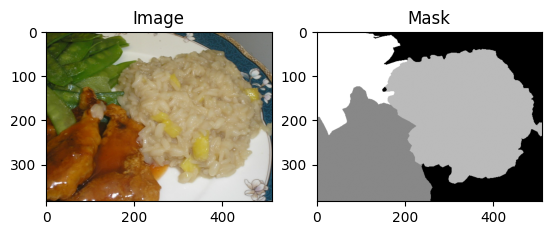

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 이미지 & 마스크 예시 로드
img = cv2.imread("FoodSeg103/Images/img_dir/train/00000000.jpg")[:,:,::-1]   # BGR → RGB
mask = cv2.imread("FoodSeg103/Images/ann_dir/train/00000000.png", cv2.IMREAD_GRAYSCALE)

print(img.shape, img.dtype)   # 예: (512, 512, 3) uint8
print(mask.shape, mask.dtype) # 예: (512, 512) uint8
print(np.unique(mask))        # 마스크 픽셀 값 확인 (클래스 개수)

# 시각화
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Mask")
plt.show()


(341, 512, 3) uint8
(341, 512) uint8
[0 5 9]


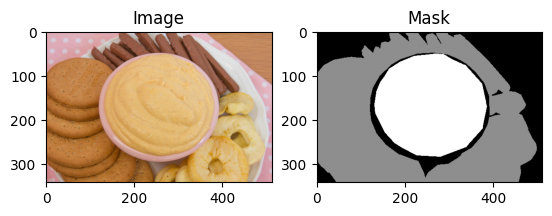

In [46]:
# 이미지 & 마스크 예시 로드
img = cv2.imread("FoodSeg103/Images/img_dir/train/00000010.jpg")[:,:,::-1]   # BGR → RGB
mask = cv2.imread("FoodSeg103/Images/ann_dir/train/00000010.png", cv2.IMREAD_GRAYSCALE)

print(img.shape, img.dtype)   # 예: (512, 512, 3) uint8
print(mask.shape, mask.dtype) # 예: (512, 512) uint8
print(np.unique(mask))        # 마스크 픽셀 값 확인 (클래스 개수)

# 시각화
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Mask")
plt.show()


In [12]:
# ===== Medium 고정 설정 (parser 제거) =====
IMG_DIR       = "FoodSeg103/Images/img_dir/train"
MASK_DIR      = "FoodSeg103/Images/ann_dir/train"
CATEGORY_FILE = "FoodSeg103/category_id.txt"
IMG_SIZE      = 256
BATCH_SIZE    = 4      # 메모리 여유 시 4까지 가능
EPOCHS        = 10
SAMPLES       = 0      # 0이면 전체 사용
IGNORE_LABEL  = 255
BASE          = 64         # Medium: 64-128-256-512 (bottleneck 1024)
DEPTH         = 4
LR            = 1e-3
SAVE_PATH = os.path.expanduser("~/sample10.keras")


# ===== Mixed Precision (Apple GPU 메모리/속도 향상) =====
tf.keras.mixed_precision.set_global_policy("mixed_float16")

print("[Path] IMG_DIR:", os.path.abspath(IMG_DIR))
print("[Path] MASK_DIR:", os.path.abspath(MASK_DIR))
print("GPU:", tf.config.list_physical_devices('GPU'))


[Path] IMG_DIR: /Users/yuntaeyeong/my_project/DL/FoodSeg103/Images/img_dir/train
[Path] MASK_DIR: /Users/yuntaeyeong/my_project/DL/FoodSeg103/Images/ann_dir/train
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
def _list(dirpath, exts=("png","jpg","jpeg")):
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(dirpath, "**", f"*.{e}"), recursive=True))
    return sorted(paths)

imgs = _list(IMG_DIR)
masks = _list(MASK_DIR, ("png","jpg","jpeg"))
img_map  = {os.path.splitext(os.path.basename(p))[0]: p for p in imgs}
mask_map = {os.path.splitext(os.path.basename(p))[0]: p for p in masks}
common = sorted(set(img_map) & set(mask_map))
if len(common) == 0:
    raise SystemExit("[Error] 이미지/마스크가 매칭되지 않습니다. 경로/파일명을 확인하세요.")
if SAMPLES and SAMPLES > 0:
    common = common[:SAMPLES]
img_paths  = [img_map[s] for s in common]
mask_paths = [mask_map[s] for s in common]
print(f"[Info] paired samples: {len(common)} (of {len(imgs)} imgs / {len(masks)} masks)")

stems = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]

# ===== NUM_CLASSES 결정: category_file 우선, 없으면 마스크로 추정 =====
if os.path.exists(CATEGORY_FILE):
    with open(CATEGORY_FILE, "r") as f:
        classes = [ln.strip() for ln in f if ln.strip()]
    NUM_CLASSES = len(classes)
    print(f"[Info] NUM_CLASSES (from file): {NUM_CLASSES} | file= {CATEGORY_FILE}")
else:
    print(f"[Warn] category_file not found: {CATEGORY_FILE}. Infer from masks (max label + 1).")
    max_label = 0
    for p in mask_paths[: min(200, len(mask_paths))]:
        mm = tf.io.read_file(p)
        mm = tf.image.decode_png(mm, channels=1)
        ml = int(tf.reduce_max(mm).numpy())
        if ml > max_label:
            max_label = ml
    NUM_CLASSES = max_label + 1
    print(f"[Info] NUM_CLASSES (inferred): {NUM_CLASSES}")

# ===== 데이터 로더 =====

def decode_image(p):
    x = tf.io.read_file(p)
    x = tf.io.decode_image(x, channels=3, expand_animations=False)
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    return x

def decode_mask(p):
    m = tf.io.read_file(p)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, (IMG_SIZE, IMG_SIZE), method="nearest")
    m = tf.cast(tf.squeeze(m, -1), tf.int32)  # [H,W]
    if IGNORE_LABEL is not None and IGNORE_LABEL >= 0:
        m = tf.where(tf.equal(m, IGNORE_LABEL), tf.zeros_like(m), m)
    # 범위 밖 라벨은 0으로 보정
    m = tf.where(tf.logical_or(m < 0, m >= NUM_CLASSES), tf.zeros_like(m), m)
    return m

@tf.function
def _augment(x, m):
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x); m = tf.image.flip_left_right(tf.expand_dims(m,-1)); m = tf.squeeze(m,-1)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x);    m = tf.image.flip_up_down(tf.expand_dims(m,-1));   m = tf.squeeze(m,-1)
    return x, m

train_n = max(1, int(len(common)*0.9))
train_img_paths = img_paths[:train_n]
train_mask_paths = mask_paths[:train_n]
train_ids = stems[:train_n]

val_img_paths = img_paths[train_n:]
val_mask_paths = mask_paths[train_n:]
val_ids = stems[train_n:]

print(f"[Split] train: {len(train_img_paths)} | val: {len(val_img_paths)}")

# datasets for training (without ids)
train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths)) \
    .shuffle(len(train_img_paths), reshuffle_each_iteration=True) \
    .map(lambda i,m: (decode_image(i), decode_mask(m)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths)) \
    .map(lambda i,m: (decode_image(i), decode_mask(m)), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(_augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# separate validation dataset WITH ids (for per-image mIoU logging)
val_eval_ds = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths, val_ids)) \
    .map(lambda i,m,idt: (decode_image(i), decode_mask(m), idt), num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


[Info] paired samples: 4983 (of 4983 imgs / 4983 masks)
[Info] NUM_CLASSES (from file): 104 | file= FoodSeg103/category_id.txt
[Split] train: 4484 | val: 499


In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# ---------------------------------------------------
# Smart preprocess: (0~1)로 들어오면 255를 곱해 ImageNet 정규화에 맞춤
# (uint8 0~255로 들어오면 그대로 사용)
# ---------------------------------------------------
def _smart_preprocess(x):
    x = tf.cast(x, tf.float32)
    maxv = tf.reduce_max(x)
    x = tf.cond(maxv <= 1.5, lambda: x * 255.0, lambda: x)
    return preprocess_input(x)

def conv_blk(x, c, use_bn=True):
    x = layers.Conv2D(c, 3, padding="same", use_bias=not use_bn)(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(c, 3, padding="same", use_bias=not use_bn)(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def build_unet_resnet50(img_size, num_classes, freeze_backbone=True, use_bn=True):
    """
    ResNet50 백본(사전학습) + U-Net 디코더
    - 입력/출력 해상도 동일 (img_size x img_size)
    - 마지막 레이어 activation=None → from_logits=True 손실과 호환
    """
    inp = layers.Input((img_size, img_size, 3), name="input")
    x_in = layers.Lambda(_smart_preprocess, name="imagenet_preprocess")(inp)

    # ------------- Encoder (Backbone) -------------
    backbone = ResNet50(include_top=False, weights="imagenet", input_tensor=x_in)
    if freeze_backbone:
        backbone.trainable = False

    # ResNet50 주요 스테이지 출력 (stride: 4/8/16/32)
    c2 = backbone.get_layer("conv2_block3_out").output  # H/4,  256 ch
    c3 = backbone.get_layer("conv3_block4_out").output  # H/8,  512 ch
    c4 = backbone.get_layer("conv4_block6_out").output  # H/16, 1024 ch
    c5 = backbone.get_layer("conv5_block3_out").output  # H/32, 2048 ch

    # ------------- Decoder (U-Net style) -------------
    # H/32 → H/16
    x = conv_blk(c5, 512, use_bn=use_bn)
    x = layers.Conv2DTranspose(512, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, c4])
    x = conv_blk(x, 512, use_bn=use_bn)

    # H/16 → H/8
    x = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, c3])
    x = conv_blk(x, 256, use_bn=use_bn)

    # H/8 → H/4
    x = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, c2])
    x = conv_blk(x, 128, use_bn=use_bn)

    # H/4 → H/2
    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(x)
    x = conv_blk(x, 64, use_bn=use_bn)

    # H/2 → H/1  (★ 출력이 입력과 동일 크기 되도록 마지막 업샘플 추가)
    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(x)
    x = conv_blk(x, 64, use_bn=use_bn)

    # ------------- Output (logits) -------------
    # from_logits=True를 쓸 것이므로 activation=None
    out = layers.Conv2D(num_classes, 1, padding="same", activation=None, name="logits")(x)

    return tf.keras.Model(inp, out, name="UNet_ResNet50Backbone")

# ===== 모델 생성 =====
model = build_unet_resnet50(img_size=IMG_SIZE, num_classes=NUM_CLASSES, freeze_backbone=True)
model.summary()

# ===== 손실/지표/학습기 =====
# from_logits=True <-- 위에서 activation=None이므로 일관성 OK
ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 네가 쓰던 mIoU 그대로 사용 가능 (argmax는 로짓/소프트맥스 둘 다 동작)
class ArgmaxMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="mIoU", **kwargs):
        super().__init__(name=name, **kwargs)
        self._miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        return self._miou.update_state(y_true, y_pred, sample_weight)
    def result(self):
        return self._miou.result()
    def reset_state(self):
        self._miou.reset_state()

# 옵티마이저/스케줄 예시
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss=ce, metrics=[ArgmaxMeanIoU(NUM_CLASSES)])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


Model: "UNet_ResNet50Backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imagenet_preprocess │ (None, 256, 256,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ imagenet_preproc… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c

 Total params: 49,691,112 (189.56 MB)

 Trainable params: 26,097,256 (99.55 MB)

 Non-trainable params: 23,593,856 (90.00 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=ce,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc"), ArgmaxMeanIoU(NUM_CLASSES)])

model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
print(f"[Done] best saved to {SAVE_PATH}")

Epoch 1/10
  36/1121 ━━━━━━━━━━━━━━━━━━━━ 23:19 1s/step - acc: 0.2911 - loss: 4.0057 - mIoU: 0.0066